In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from tqdm import tqdm

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = "cuda:0" 
else:
    device = "cpu" 

In [2]:
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import accuracy_score
import csv


def Partial_Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

def calculate_metrics(y_true, y_pred_prob, partial = False):
    # Calculate accuracy
    y_pred = (y_pred_prob > 0.5).astype(int)
    num_labels = y_true.shape[1]
    if partial:
        accuracy = Partial_Accuracy(y_true, y_pred)
    else:
        accuracy = accuracy_score(y_true, y_pred)
    
    auroc_scores = []
    for class_idx in range(5):        
        class_true = y_true[:, class_idx]
        class_pred = y_pred_prob[:, class_idx]
        auroc = roc_auc_score(class_true, class_pred)
        auroc_scores.append(auroc)

    macro_auroc = np.mean(auroc_scores)
    
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    
    return accuracy, macro_auroc, micro_f1

def SaveCsvForPlot(filename, train_acc_plot, train_auroc_plot, train_f1_plot, val_acc_plot, val_auroc_plot, val_f1_plot):
    data = [(a,b,c,d,e,f) for a,b,c,d,e,f in zip(train_acc_plot, train_auroc_plot, train_f1_plot, val_acc_plot, val_auroc_plot, val_f1_plot)]
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)


def train(model, train_set, test_set, batch_size, epochs, lr, csv_name = "report"):
    dev = "cuda:0"
    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_set, batch_size = batch_size)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_acc_plot = []
    train_auroc_plot = []
    train_f1_plot = []
    val_acc_plot = []
    val_auroc_plot = []
    val_f1_plot = []

    for epoch in range(epochs):
        
        train_labels_all = []
        train_probs_all = []
        val_labels_all = []
        val_probs_all = []
        
        model.train()
        for x, y in tqdm(train_loader):
            x, y = x.to(dev).float(), y.to(dev).float()
            optimizer.zero_grad()
            output=model(x).float()
            loss=loss_function(output,y)
            loss.backward()
            optimizer.step()
            train_probs_all.append(torch.sigmoid(output).detach().cpu().numpy())
            train_labels_all.append(y.detach().cpu().numpy())
        
        train_probs_all = np.concatenate(train_probs_all)
        train_labels_all = np.concatenate(train_labels_all)
        train_accuracy, train_macro_auroc, train_micro_f1 = calculate_metrics(train_labels_all, train_probs_all)
        train_acc_plot.append(train_accuracy)
        train_auroc_plot.append(train_macro_auroc)
        train_f1_plot.append(train_micro_f1)
        
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(test_loader):
                x, y = x.to(dev).float(), y.to(dev).to(torch.int64)
                output=model(x).float()
                val_probs_all.append(torch.sigmoid(output).cpu().numpy())
                #val_probs = output.cpu().numpy()
                val_labels_all.append(y.cpu().numpy())
        
        val_probs_all = np.concatenate(val_probs_all)
        val_labels_all = np.concatenate(val_labels_all)
        val_accuracy, val_macro_auroc, val_micro_f1 = calculate_metrics(val_labels_all, val_probs_all)
        val_acc_plot.append(val_accuracy)
        val_auroc_plot.append(val_macro_auroc)
        val_f1_plot.append(val_micro_f1)
        
        print(f"Epoch {epoch+1}:")
        print(f"Train: accuracy = {train_accuracy}, AUROC = {train_macro_auroc}, F1 = {train_micro_f1}")  
        print(f"Test: accuracy = {val_accuracy}, AUROC = {val_macro_auroc}, F1 = {val_micro_f1}")
        SaveCsvForPlot(f"{csv_name}.csv", train_acc_plot, train_auroc_plot, train_f1_plot, val_acc_plot, val_auroc_plot, val_f1_plot)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

X_train = np.load('/kaggle/input/ptb-xl-fold-6/PTB-XL_X_train.npy', allow_pickle=True)
y_train = np.load('/kaggle/input/ptb-xl-fold-6/PTB-XL_y_train.npy', allow_pickle=True)
X_test = np.load('/kaggle/input/ptb-xl-fold-6/PTB-XL_X_test.npy', allow_pickle=True)
y_test = np.load('/kaggle/input/ptb-xl-fold-6/PTB-XL_y_test.npy',allow_pickle=True)
mlb = MultiLabelBinarizer()
mlb.fit(y_train)
y_train_onehot = mlb.transform(y_train)
y_test_onehot = mlb.transform(y_test)

In [4]:
class ECG_Data(Dataset):
    def __init__(self, x, y, mode = '1d'):
        self.x = x
        self.y = y
        self.mode = mode
    
    def __getitem__(self,index):
        x = self.x[index]
        if self.mode == '1d':
            x = x.reshape(12, 1000)
        elif self.mode == '2d':
            x = x.reshape(12, 1, 1000)
        label = self.y[index]
        return torch.from_numpy(x).float(), torch.from_numpy(label).float()
    
    def __len__(self):
        return len(self.y)

    
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsample=None):
        super(ResBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        #print(out.shape)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        #print(out.shape)

        if self.downsample is not None:
            out = self.maxpool(out)
            identity = self.downsample(x)

        out += identity
        # print(out.shape)

        return out
    
class ECGNet(nn.Module):

    def __init__(self, struct=[15, 17, 19, 21], in_channels= 12, fixed_kernel_size=17, num_classes=5):
        super(ECGNet, self).__init__()
        self.struct = struct
        self.planes = 16
        self.parallel_conv = nn.ModuleList()

        for i, kernel_size in enumerate(struct):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=kernel_size,
                               stride=1, padding=0, bias=False)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_layer(kernel_size=fixed_kernel_size, stride=1, padding=8)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=8, stride=8, padding=2)
        self.rnn = nn.LSTM(input_size=12, hidden_size=40, num_layers=1, bidirectional=False)
        self.fc = nn.Linear(in_features=168, out_features=num_classes)


    def _make_layer(self, kernel_size, stride, blocks=15, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            if (i + 1) % 4 == 0:
                downsample = nn.Sequential(
                    nn.Conv1d(in_channels=self.planes, out_channels=self.planes + base_width, kernel_size=1,
                               stride=1, padding=0, bias=False),
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
                layers.append(ResBlock(in_channels=self.planes, out_channels=self.planes + base_width, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsample=downsample))
                self.planes += base_width
            elif (i + 1) % 2 == 0:
                downsample = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
                layers.append(ResBlock(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsample=downsample))
            else:
                downsample = None
                layers.append(ResBlock(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsample=downsample))

        return nn.Sequential(*layers)



    def forward(self, x):
        out_sep = []

        for i in range(len(self.struct)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  # out => [b, 16, 9960]

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  # out => [b, 64, 10]
        out = out.reshape(out.shape[0], -1)  # out => [b, 640]

        rnn_out, (rnn_h, rnn_c) = self.rnn(x.permute(2, 0, 1))
        new_rnn_h = rnn_h[-1, :, :]  # rnn_h => [b, 40]

        new_out = torch.cat([out, new_rnn_h], dim=1)  # out => [b, 680]
        result = self.fc(new_out)  # out => [b, 20]

        # print(out.shape)

        return result

In [5]:
trainset = ECG_Data(X_train, y_train_onehot)
testset = ECG_Data(X_test, y_test_onehot)

In [6]:
num_classes = 5
model = ECGNet().float().to('cuda:0')
train(model, trainset, testset, batch_size = 64,  epochs = 10, lr = 0.001, csv_name = "CNN1D")

100%|██████████| 34/34 [00:00<00:00, 59.64it/s]


Epoch 1:
Train: accuracy = 0.34061958626312033, AUROC = 0.7579050136479861, F1 = 0.45619486504279133
Test: accuracy = 0.3294983893235159, AUROC = 0.8127135453827057, F1 = 0.5390858607432721


100%|██████████| 34/34 [00:00<00:00, 62.77it/s]


Epoch 2:
Train: accuracy = 0.4529705492713747, AUROC = 0.8386654570453953, F1 = 0.6108600399164965
Test: accuracy = 0.47215830648872525, AUROC = 0.853894059413966, F1 = 0.6165222903021339


100%|██████████| 34/34 [00:00<00:00, 61.95it/s]


Epoch 3:
Train: accuracy = 0.4992357077346377, AUROC = 0.8642429869709988, F1 = 0.6564283955315766
Test: accuracy = 0.5080533824206167, AUROC = 0.8648777972906988, F1 = 0.6303947637553692


100%|██████████| 34/34 [00:00<00:00, 60.26it/s]


Epoch 4:
Train: accuracy = 0.5288392948130032, AUROC = 0.8794572586482922, F1 = 0.682693156732892
Test: accuracy = 0.5301426599171652, AUROC = 0.8734355853586555, F1 = 0.6683989606236258


100%|██████████| 34/34 [00:00<00:00, 59.61it/s]


Epoch 5:
Train: accuracy = 0.5506980536023642, AUROC = 0.8893093235237561, F1 = 0.7018727412112583
Test: accuracy = 0.4767602393005062, AUROC = 0.8786866427543666, F1 = 0.6558689024390244


100%|██████████| 34/34 [00:00<00:00, 58.91it/s]


Epoch 6:
Train: accuracy = 0.5654234179150107, AUROC = 0.8970249617560858, F1 = 0.7173837461973055
Test: accuracy = 0.5540727105384261, AUROC = 0.8795009606755109, F1 = 0.6772892295280356


100%|██████████| 34/34 [00:00<00:00, 60.26it/s]


Epoch 7:
Train: accuracy = 0.579384489962295, AUROC = 0.9042037559128675, F1 = 0.7278079612112817
Test: accuracy = 0.5591348366313852, AUROC = 0.8869165161656187, F1 = 0.6938373695609371


100%|██████████| 34/34 [00:00<00:00, 60.06it/s]


Epoch 8:
Train: accuracy = 0.589473147865077, AUROC = 0.9107234898923876, F1 = 0.7386145034043013
Test: accuracy = 0.5494707777266452, AUROC = 0.887369758663057, F1 = 0.6902336728579987


100%|██████████| 34/34 [00:00<00:00, 60.14it/s]


Epoch 9:
Train: accuracy = 0.5983898909609702, AUROC = 0.9139326587317406, F1 = 0.7473278995247209
Test: accuracy = 0.54348826507133, AUROC = 0.8870978669053603, F1 = 0.6961808854265628


100%|██████████| 34/34 [00:00<00:00, 58.91it/s]

Epoch 10:
Train: accuracy = 0.6086823601345155, AUROC = 0.9205257414155297, F1 = 0.755114719681227
Test: accuracy = 0.5407271053842614, AUROC = 0.8870778871598031, F1 = 0.6903831118060986


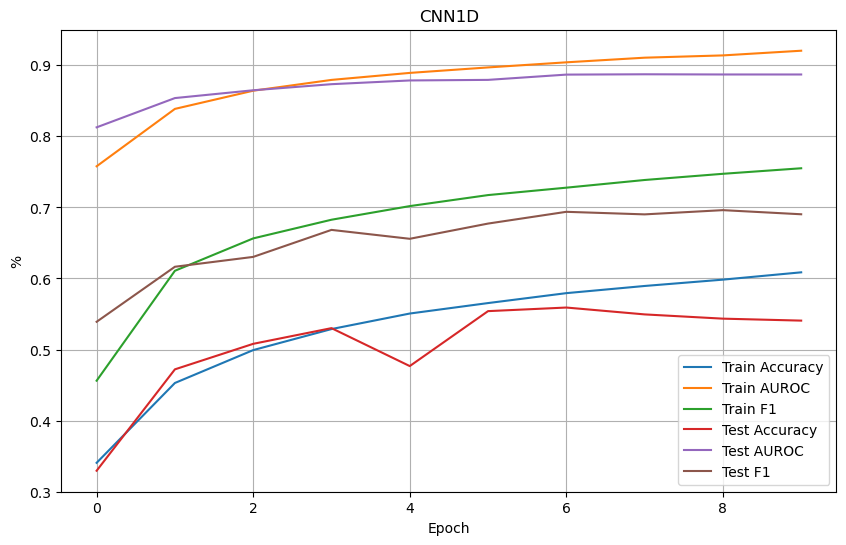

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

CNN1D_Result = pd.read_csv("/kaggle/working/CNN1D.csv", header = None)

# Plotting all models together
plt.figure(figsize=(10, 6))

plt.plot(CNN1D_Result[0], label='Train Accuracy')
plt.plot(CNN1D_Result[1], label='Train AUROC')
plt.plot(CNN1D_Result[2], label='Train F1')
plt.plot(CNN1D_Result[3], label='Test Accuracy')
plt.plot(CNN1D_Result[4], label='Test AUROC')
plt.plot(CNN1D_Result[5], label='Test F1')

plt.title('CNN1D')
plt.xlabel('Epoch')
plt.ylabel('%')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
class ResNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=5, pretrained = False, freeze = False):
        super(ResNet, self).__init__()
        if pretrained:
            self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.model = models.resnet18(weights = None)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.fc.parameters():
                param.requires_grad = True


    def forward(self, x):
        return self.model(x)

In [9]:
trainset = ECG_Data(X_train, y_train_onehot, mode = '2d')
testset = ECG_Data(X_test, y_test_onehot, mode = '2d')

In [10]:
model = ResNet(in_channels = 12).float().to('cuda:0')
train(model, trainset, testset, batch_size = 64,  epochs = 10, lr = 0.001, csv_name = "ResNet18")

100%|██████████| 34/34 [00:01<00:00, 33.83it/s]


Epoch 1:
Train: accuracy = 0.37903801080199734, AUROC = 0.7877367747407563, F1 = 0.5221393275845363
Test: accuracy = 0.40266912103083297, AUROC = 0.8370006417410117, F1 = 0.5982023331420921


100%|██████████| 34/34 [00:01<00:00, 33.91it/s]


Epoch 2:
Train: accuracy = 0.4507286252929787, AUROC = 0.8418638864347002, F1 = 0.6169233573316322
Test: accuracy = 0.446387482742752, AUROC = 0.8578820902839664, F1 = 0.6120152702431184


100%|██████████| 34/34 [00:00<00:00, 34.15it/s]


Epoch 3:
Train: accuracy = 0.4906246815448894, AUROC = 0.861474471175519, F1 = 0.6518070941031665
Test: accuracy = 0.5039116428900138, AUROC = 0.8686118909079761, F1 = 0.6678141135972462


100%|██████████| 34/34 [00:01<00:00, 33.99it/s]


Epoch 4:
Train: accuracy = 0.513757260776521, AUROC = 0.8766553447702788, F1 = 0.6767754572063646
Test: accuracy = 0.5296824666359871, AUROC = 0.8703838175926151, F1 = 0.6713203031511766


100%|██████████| 34/34 [00:00<00:00, 34.05it/s]


Epoch 5:
Train: accuracy = 0.5378069907265872, AUROC = 0.8871774209454841, F1 = 0.6989583105850494
Test: accuracy = 0.5112747353888634, AUROC = 0.8650361629697574, F1 = 0.660832360949047


100%|██████████| 34/34 [00:00<00:00, 34.18it/s]


Epoch 6:
Train: accuracy = 0.5536023642107408, AUROC = 0.8948480735202334, F1 = 0.711914486834101
Test: accuracy = 0.5181776346065348, AUROC = 0.8788011793370721, F1 = 0.6879323597232897


100%|██████████| 34/34 [00:01<00:00, 33.19it/s]


Epoch 7:
Train: accuracy = 0.5659329460919189, AUROC = 0.9019762945921043, F1 = 0.7260359757282603
Test: accuracy = 0.5526921306948919, AUROC = 0.8798148689228882, F1 = 0.678060413354531


100%|██████████| 34/34 [00:00<00:00, 34.09it/s]


Epoch 8:
Train: accuracy = 0.5747477835524305, AUROC = 0.909272846234624, F1 = 0.7340779009196338
Test: accuracy = 0.5517717441325357, AUROC = 0.8750182903279343, F1 = 0.675


100%|██████████| 34/34 [00:00<00:00, 34.00it/s]


Epoch 9:
Train: accuracy = 0.5940079486395597, AUROC = 0.9161751133437643, F1 = 0.7511674735444068
Test: accuracy = 0.5163368614818223, AUROC = 0.8811999246373565, F1 = 0.6790293943578616


100%|██████████| 34/34 [00:00<00:00, 34.13it/s]


Epoch 10:
Train: accuracy = 0.6044532762661775, AUROC = 0.92369434399067, F1 = 0.7612922460974934
Test: accuracy = 0.4965485503911643, AUROC = 0.877690266269543, F1 = 0.6771741145929908


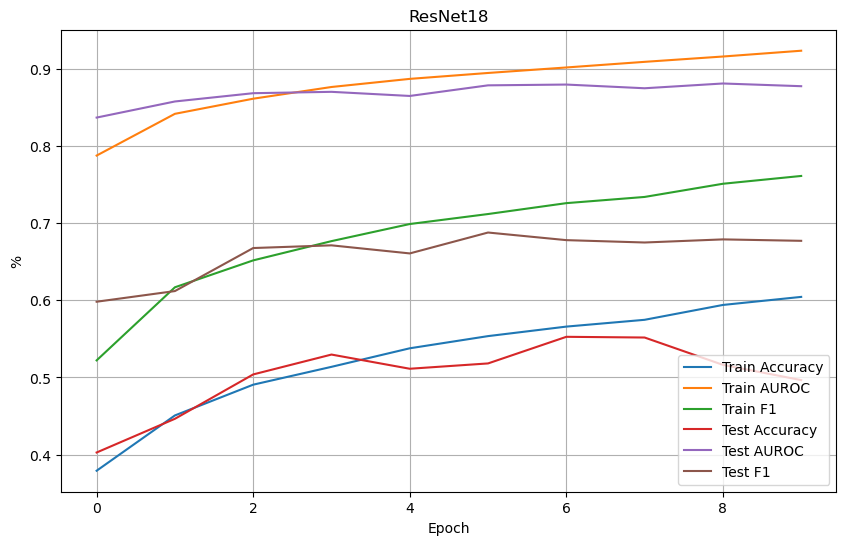

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

ResNet_Result = pd.read_csv("/kaggle/working/ResNet18.csv", header = None)

# Plotting all models together
plt.figure(figsize=(10, 6))

plt.plot(ResNet_Result[0], label='Train Accuracy')
plt.plot(ResNet_Result[1], label='Train AUROC')
plt.plot(ResNet_Result[2], label='Train F1')
plt.plot(ResNet_Result[3], label='Test Accuracy')
plt.plot(ResNet_Result[4], label='Test AUROC')
plt.plot(ResNet_Result[5], label='Test F1')

plt.title('ResNet18')
plt.xlabel('Epoch')
plt.ylabel('%')
plt.legend()
plt.grid(True)
plt.show()

### Result
* CNN1D: 使用了Capstone Project要用的Model ECGNet(結合1dCNN, ResNet 與 LSTM)，但表現比預期的差，需要研究如何將其應用於PTB-XL資料
* ResNet: Test的AUROC卡在87上下，表現略差於ECGNet